# Explore the dataset

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:

class MinMaxScaler:
    def __init__(self, data, min_=0, max_=1) -> None:
        self.data_min = np.min(data)
        self.data_max = np.max(data)
        self.min_ = min_
        self.max_ = max_

    def transform(self, x):
        d_diff = self.data_max - self.data_min + 1e-32
        s_diff = self.max_ - self.min_
        return (x - self.data_min) / d_diff * s_diff + self.min_

    def inverse_transform(self, x):
        d_diff = self.data_max - self.data_min + 1e-32
        s_diff = self.max_ - self.min_
        return (x - self.min_) / s_diff * d_diff + self.data_min



class ChannelMinMaxScaler(MinMaxScaler):
    def __init__(self, data, axis_apply, min_=0, max_=1) -> None:
        super().__init__(data, min_, max_)
        self.data_min = np.nanmin(data, axis=axis_apply, keepdims=True)
        self.data_max = np.nanmax(data, axis=axis_apply, keepdims=True)
        

In [3]:
# plot utilies

def plot_field(field):
    '''field: shape [x, y]'''
    fig, axs = plt.subplots(4,4, figsize=(10,8))
    for i, ax in enumerate(axs.ravel()):
        im = ax.imshow(field[...,i].T, 
                cmap='seismic',
                origin='lower',
                aspect='auto')
        ax.set_box_aspect(1)
        ax.axis('off')
        fig.colorbar(im)
    plt.tight_layout()
    plt.show()
    return fig



In [4]:
# Load the data set

data = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/varyGM/thedataset2.hdf5', 'r')
print(data.keys())
print(len(data.keys()))

<KeysViewHDF5 ['forward_0', 'forward_1', 'forward_10', 'forward_11', 'forward_12', 'forward_13', 'forward_14', 'forward_15', 'forward_16', 'forward_17', 'forward_18', 'forward_19', 'forward_2', 'forward_20', 'forward_21', 'forward_22', 'forward_23', 'forward_24', 'forward_25', 'forward_26', 'forward_27', 'forward_28', 'forward_29', 'forward_3', 'forward_30', 'forward_31', 'forward_32', 'forward_33', 'forward_34', 'forward_35', 'forward_36', 'forward_37', 'forward_38', 'forward_39', 'forward_4', 'forward_40', 'forward_41', 'forward_42', 'forward_43', 'forward_44', 'forward_45', 'forward_46', 'forward_47', 'forward_48', 'forward_49', 'forward_5', 'forward_50', 'forward_51', 'forward_52', 'forward_53', 'forward_54', 'forward_55', 'forward_56', 'forward_57', 'forward_58', 'forward_59', 'forward_6', 'forward_60', 'forward_61', 'forward_62', 'forward_63', 'forward_64', 'forward_65', 'forward_66', 'forward_67', 'forward_68', 'forward_69', 'forward_7', 'forward_70', 'forward_71', 'forward_72',

(30, 60, 100, 100, 17)
[[[[[-1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34
     -1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34 -1.e+34
      0.e+00]]]]]
[[[[[1.08244258e-03 3.09710072e-06 1.39847267e+00 1.30534658e+01
     9.99363403e+02 2.61778350e-05 3.42435799e+01 0.00000000e+00
     1.14333176e-07 5.93310129e-03 1.88417664e+01 0.00000000e+00
     1.38871774e-05 2.90362234e-03 9.06503260e-01 1.64067554e+00
     6.00000000e+02]]]]]


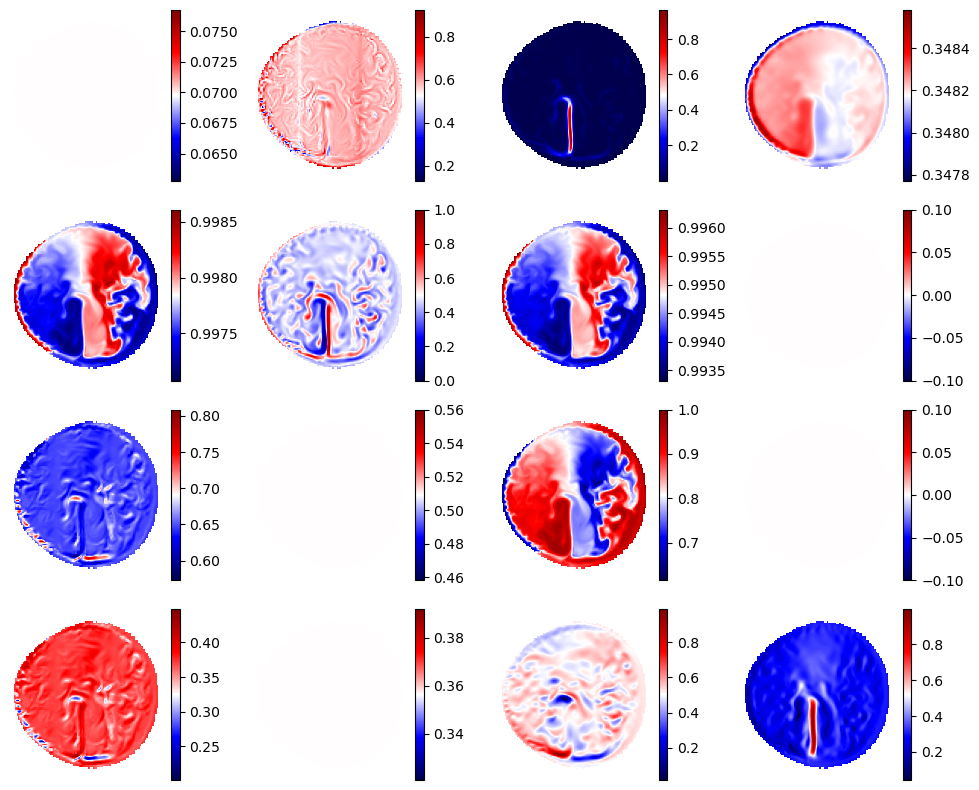

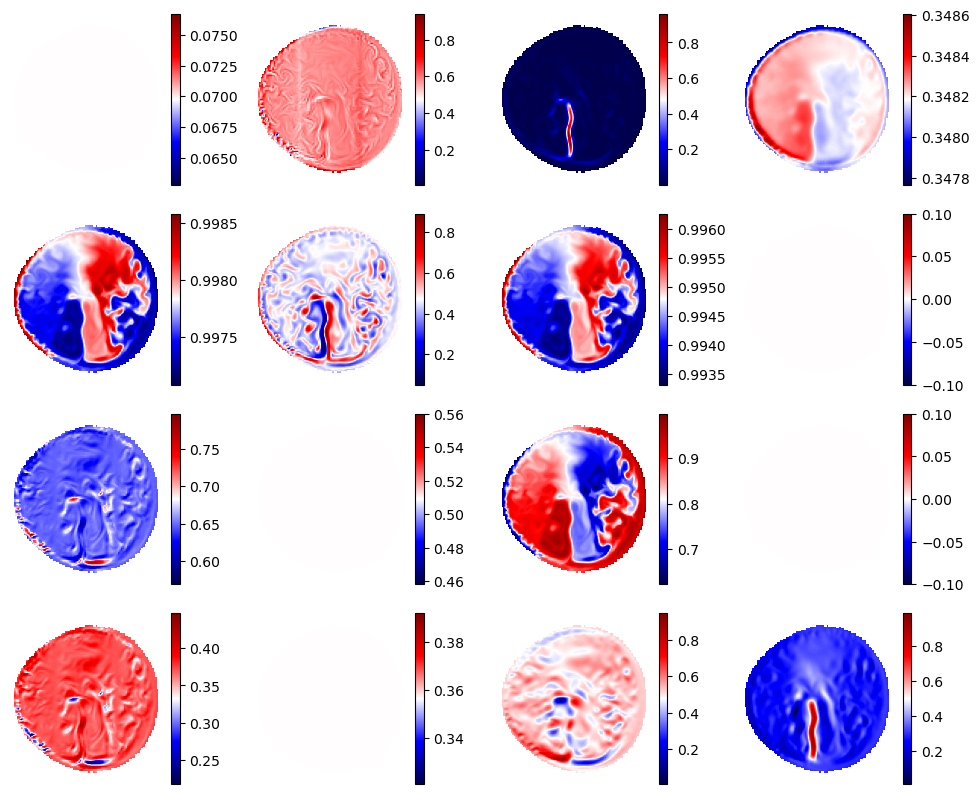

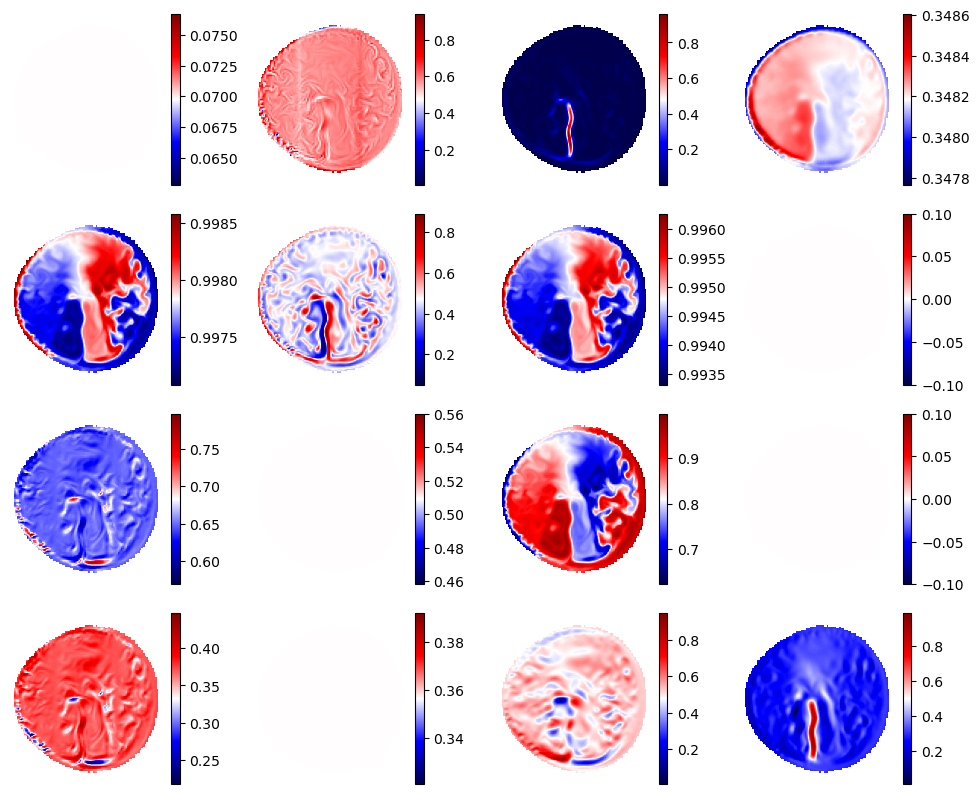

In [6]:
forward_0 = data['forward_0'][...]
print(forward_0.shape)
print(np.min(forward_0, axis=(0,1,2,3), keepdims=True))
print(np.max(forward_0, axis=(0,1,2,3), keepdims=True))



mask1 = forward_0 < -1e16
mask2 = forward_0 > 1e16

mask = np.logical_or(mask1, mask2)

# forward_0[mask1] = np.nan
# forward_0[mask2] = np.nan
forward_0[mask] = np.nan


scaler = ChannelMinMaxScaler(forward_0, (0, 1, 2, 3))
forward_0 = scaler.transform(forward_0)


# import pickle

# with open('../tmp/SOMA_mask.pkl', 'wb') as f:
#     mask = {'mask1': mask1, 'mask2': mask2}
#     pickle.dump(mask, f)
plot_field(forward_0[0, 0, :, :,: ])
plot_field(forward_0[15, 0, :, :,: ])

# get the min max for all variables from the first example
# for i in range(forward_0.shape[-1]):
#     print((np.nanmin(forward_0[..., i]), np.nanmax(forward_0[..., i])))


# investigate where 0 is coming from in GM
# mask_0 = forward_0[...,-1] == 0
# a = forward_0
# a[mask_0] = 500
# for i in range(forward_0.shape[0]):
#     plt.imshow(a[i,0, ..., -1], cmap='seismic')
#     plt.show()



In [18]:
# load prediction data
import pickle 

with open('/pscratch/sd/y/yixuans/2023-07-26-true_pred.pkl', 'rb') as f:
    data = pickle.load(f)

true = data['true'][0]
pred = data['pred'][0]

print(pred.shape)


true = np.transpose(true, axes=(0, 2, 3, 4, 1))
pred = np.transpose(pred, axes=(0, 2, 3, 4, 1))
print(pred.shape)

print(true.shape)
mask_b = mask[0:1,0:1,:,:,0:1]
mask_b = np.broadcast_to(mask_b, true.shape)
print(mask_b.shape)
true[mask_b] = np.nan
pred[mask_b] = np.nan
print(true.shape, pred.shape)
plot_field(true[0,0,...])
plot_field(pred[0,0, ...])


(29, 16, 60, 100, 100)
(29, 100, 100, 16, 60)
(29, 60, 100, 100, 16)
(29, 60, 100, 100, 16)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 100 but corresponding boolean dimension is 60